In [1]:
!pip install -q open3d==0.13.0
!pip install -q numpy==1.19.5
!pip install -q scikit-learn==0.24.2
!pip install -q pandas==1.1.5
!pip install -q matplotlib==3.3.4
!pip install -q seaborn==0.11.2

# Step 1: Read STL file and convert into .ply format

In [2]:
import open3d as o3d
import numpy as np

# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# parameters
MESH_STL_PATH = '/home/slayer/CV_Engg/model.stl'
OUTPUT_PLY_PATH = "copy_of_knot.ply"


In [4]:
# reading model.stl file and converting it into .ply using open3d 

mesh = o3d.io.read_triangle_mesh(MESH_STL_PATH)
o3d.io.write_triangle_mesh(OUTPUT_PLY_PATH, mesh)
pcd = o3d.io.read_point_cloud(OUTPUT_PLY_PATH)

In [5]:
points = np.asarray(pcd.points)

# Step 2: Point-cloud clustering using Gaussian Mix modeling (Expectation-Maximization) technique 

In [6]:
points = pd.DataFrame(points)
points.columns = ['x', 'y', 'z']
points_z = points[points['z'].between(5, 15)].copy()
points_z['y'] = points_z['y'] + 200 #compensating for offset along y-axis


## Step 2.1: Fitting a GMM Model with 5 components

In [7]:
gmm = GaussianMixture(n_components=5)
gmm.fit(points_z)

GaussianMixture(n_components=5)

In [8]:
# print cluster centroids for the 5 clusters

gmm.means_

array([[ 99.45290654,  99.2354126 ,  14.05077283],
       [170.67478733,  21.68246856,   8.82758596],
       [ 19.10187472, 177.41606019,   7.84768385],
       [116.99414149, 180.78916093,  13.39825449],
       [ 74.78120143,  18.06096315,  13.30011484]])

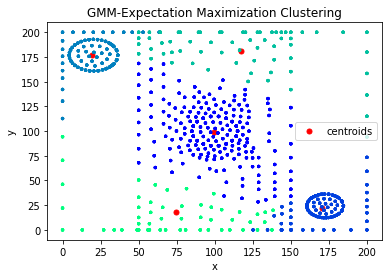

In [9]:
# 2D Visualization of clusters with 5 component GMM-EM model
fig = plt.figure()
ax = fig.add_subplot(111 )
scatter = ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
            # kmeans.cluster_centers_[:, 2],
            s=25,
            marker='o',
            c='red',
            label='centroids')

scatter = ax.scatter(points_z['x'],points_z['y'], # points_df['z'],
                     c=gmm.predict(points_z), s=5, cmap='winter')


ax.set_title('GMM-Expectation Maximization Clustering')
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.set_zlabel('z')
ax.legend()
plt.show()

Since the clusters are not very prominent, I am experimenting the same model with 6 components

## Step 2.2: GMM model with 6 components

In [11]:
gmm_6 = GaussianMixture(n_components=6, random_state=2122)
gmm_6.fit(points_z)

GaussianMixture(n_components=6, random_state=2122)

In [12]:
# print cluster centroids for the 6 clusters
gmm_6.means_

array([[ 19.46138325, 178.54082997,   7.83498864],
       [100.25102226,  98.70886395,  15.        ],
       [158.79561112, 168.19774348,   8.84570134],
       [ 42.38000739,  25.6718236 ,   8.83730058],
       [ 99.96796042,  99.94309417,  10.84906545],
       [173.89438735,  22.02928905,   8.11737264]])

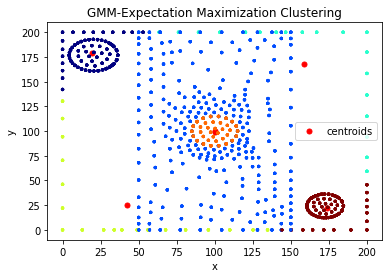

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111) #, projection='3d' 
scatter = ax.scatter(gmm_6.means_[:, 0], gmm_6.means_[:, 1],#, gmm_6.means_[:, 2],
            # kmeans.cluster_centers_[:, 2],
            s=25,
            marker='o',
            c='red',
            label='centroids')

scatter = ax.scatter(points_z['x'],points_z['y'],#, points_z['z'],
                     c=gmm_6.predict(points_z), s=5, cmap='jet')


ax.set_title('GMM-Expectation Maximization Clustering')
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.set_zlabel('z')
ax.legend()
plt.show()

In [14]:
points_z.shape, pd.Series(gmm_6.predict(points_z)).shape

((3224, 3), (3224,))

In [15]:
points_z_data = points_z.copy()
points_z_data['cluster'] = gmm_6.predict(points_z)

In [16]:
points_z_data['cluster'].value_counts()

1    1664
0     521
5     493
4     318
3     114
2     114
Name: cluster, dtype: int64

In [17]:
def plot_scatter(data, cluster):
    cluster_data = data[data['cluster'] == cluster]
    sns.scatterplot(x=cluster_data['x'], y=cluster_data['y'])


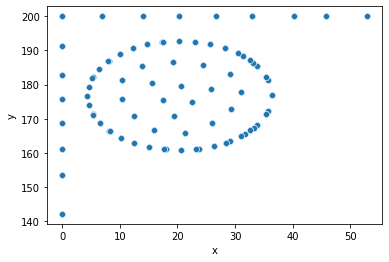

In [18]:
plot_scatter(points_z_data, 0)

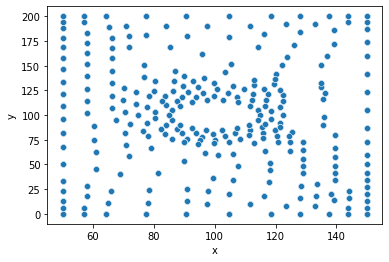

In [19]:
plot_scatter(points_z_data, 1)

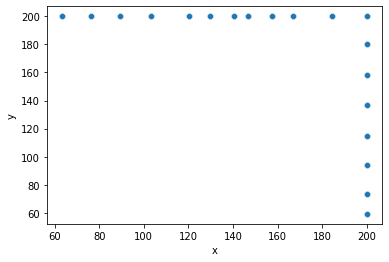

In [20]:
plot_scatter(points_z_data, 2)

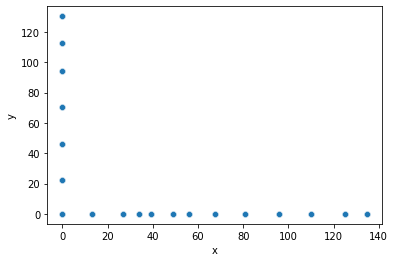

In [21]:
plot_scatter(points_z_data, 3)

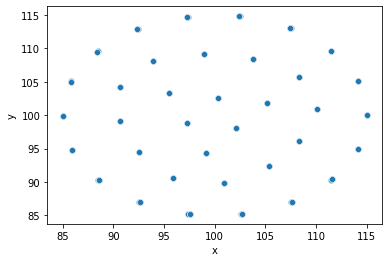

In [22]:
plot_scatter(points_z_data, 4)

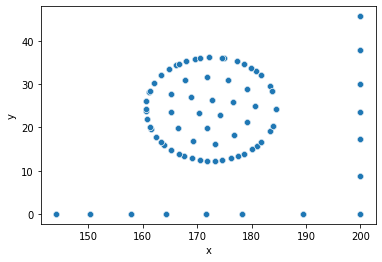

In [23]:
plot_scatter(points_z_data, 5)

## Only useful clusters are 
1. `cluster_5` correspoinding to the right-most hole
2. `cluster_0` corresponding to the left hole
3. `cluster_4` corresponding to the center hole
   


In [24]:
cluster_5 = points_z_data[points_z_data['cluster'] == 5] # right bottom hole
cluster_0 = points_z_data[points_z_data['cluster'] == 0] # left hole
cluster_4 = points_z_data[points_z_data['cluster'] == 4] # center hole

<AxesSubplot:xlabel='x', ylabel='y'>

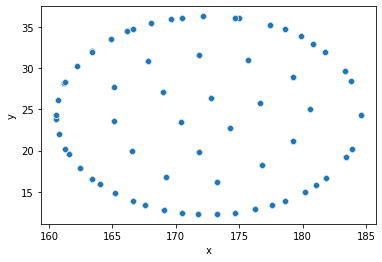

In [25]:
cluster_5 = cluster_5.loc[(cluster_5['y'] != 0) & (cluster_5['x'] != 200), :]
sns.scatterplot(x=cluster_5['x'], y=cluster_5['y'])


In [57]:
f"right most hole diameter in mm: {np.floor(cluster_5['x'].max() - cluster_5['x'].min())}"

'right most hole diameter in mm: 23.0'

<AxesSubplot:xlabel='x', ylabel='y'>

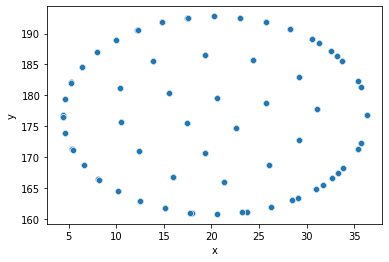

In [58]:
cluster_0 = cluster_0.loc[(cluster_0['x'] != 0) & (cluster_0['y'] != 200), :]
sns.scatterplot(x=cluster_0['x'],y=cluster_0['y'])

In [60]:
f"left most hole diameter in mm: {np.floor(cluster_0['x'].max() - cluster_0['x'].min())}"

'left most hole diameter in mm: 31.0'

In [63]:

f"center hole diameter in mm: {np.floor(cluster_4['x'].max() - cluster_4['x'].min())}"

'center hole diameter in mm: 29.0'

In [62]:
gmm_6.means_[[0, 4, 5], :]
mean_centres = gmm_6.means_[[0, 4, 5], :]

print(f"left most cluster depth in mm: {np.floor(mean_centres[0][2])}")
print(f"right most cluster depth in mm: {np.floor(mean_centres[2][2])}")
print(f"middle cluster depth in mm: {np.floor(mean_centres[1][2])}")

left most cluster depth in mm: 7.0
right most cluster depth in mm: 8.0
middle cluster depth in mm: 10.0


In [61]:
#printing x,y coordinates of clusters (holes)
print(f"left cluster center in mm: {np.floor((mean_centres[0][0], mean_centres[0][1]))}")
print(f"right cluster center in mm: {np.floor((mean_centres[2][0], mean_centres[2][1]))}")
print(f"middle cluster center in mm: {np.floor((mean_centres[1][0], mean_centres[1][1]))}")

left cluster center in mm: [ 19. 178.]
right cluster center in mm: [173.  22.]
middle cluster center in mm: [99. 99.]


# Problem 1.3

In [64]:
import cv2
row = np.array([0,0,1])
object_points = np.array(gmm_6.means_[[0, 4, 5], :], dtype=np.float64)
object_points = np.vstack([row, object_points])

image_points = np.array([
                        (622,790), #center of image in pixels
                        (230,142),  
                        (394,304),
                        (546,466)
                        ], dtype="double")

camera_matrix = np.array([(790,0,395), (0,622,311), (0,0,1)], dtype = np.float64)
dist_coeffs = np.zeros((4,1)) 
ret, rotation_vector, translation_vector = cv2.solvePnP(object_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_P3P)
rotation_matrix, _ = cv2.Rodrigues(rotation_vector)


In [33]:
print("translation_vector: ",translation_vector/1000)
print("rotation_vector: ", rotation_matrix)

translation_vector:  [[0.0461086 ]
 [0.12642328]
 [0.16365877]]
rotation_vector:  [[-0.1751448  -0.38697802  0.90530233]
 [-0.46176142 -0.77982174 -0.42267535]
 [ 0.86954051 -0.49206308 -0.0421098 ]]
